# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings

warnings.filterwarnings('ignore')


# Load Data

In [2]:
df1 = pd.read_csv('/content/sales_data_january_2019.csv')
df2 = pd.read_csv('/content/sales_data_february_2019.csv')
df3 = pd.read_csv('/content/sales_data_march_2019.csv')
df4 = pd.read_csv('/content/sales_data_april_2019.csv')
df5 = pd.read_csv('/content/sales_data_may_2019.csv')
df6 = pd.read_csv('/content/sales_data_june_2019.csv')
df7 = pd.read_csv('/content/sales_data_july_2019.csv')
df8 = pd.read_csv('/content/sales_data_august_2019.csv')
df9 = pd.read_csv('/content/sales_data_september_2019.csv')
df10 = pd.read_csv('/content/sales_data_october_2019.csv')
df11 = pd.read_csv('/content/sales_data_november_2019.csv')
df12 = pd.read_csv('/content/sales_data_december_2019.csv')

In [3]:
# gabung data
df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12], ignore_index=True)
df

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,141234,iPhone,1,700,01/22/19 21:25,"944 Walnut St, Boston, MA 02215"
1,141235,Lightning Charging Cable,1,14.95,01/28/19 14:15,"185 Maple St, Portland, OR 97035"
2,141236,Wired Headphones,2,11.99,01/17/19 13:33,"538 Adams St, San Francisco, CA 94016"
3,141237,27in FHD Monitor,1,149.99,01/05/19 20:33,"738 10th St, Los Angeles, CA 90001"
4,141238,Wired Headphones,1,11.99,01/25/19 11:59,"387 10th St, Austin, TX 73301"
...,...,...,...,...,...,...
186845,319666,Lightning Charging Cable,1,14.95,12/11/19 20:58,"14 Madison St, San Francisco, CA 94016"
186846,319667,AA Batteries (4-pack),2,3.84,12/01/19 12:01,"549 Willow St, Los Angeles, CA 90001"
186847,319668,Vareebadd Phone,1,400,12/09/19 06:43,"273 Wilson St, Seattle, WA 98101"
186848,319669,Wired Headphones,1,11.99,12/03/19 10:39,"778 River St, Dallas, TX 75001"


# Data Understanding

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186850 entries, 0 to 186849
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Order ID          186305 non-null  object
 1   Product           186305 non-null  object
 2   Quantity Ordered  186305 non-null  object
 3   Price Each        186305 non-null  object
 4   Order Date        186305 non-null  object
 5   Purchase Address  186305 non-null  object
dtypes: object(6)
memory usage: 8.6+ MB


In [5]:
df.describe()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
count,186305,186305,186305,186305,186305,186305
unique,178438,20,10,24,142396,140788
top,Order ID,USB-C Charging Cable,1,11.95,Order Date,Purchase Address
freq,355,21903,168552,21903,355,355


# Data Preprocessing

## Convert Data Type

In [6]:
df['Quantity Ordered'] = pd.to_numeric(df['Quantity Ordered'], errors='coerce')
df['Price Each'] = pd.to_numeric(df['Price Each'], errors='coerce')
df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')

## Check and Handling Missing Values

In [7]:
df.isna().sum() / df.shape[0] * 100

,0
Order ID,0.291678
Product,0.291678
Quantity Ordered,0.481670
Price Each,0.481670
Order Date,0.481670
Purchase Address,0.291678


In [8]:
df = df.dropna()
df.isna().sum() / df.shape[0] * 100

,0
Order ID,0.0
Product,0.0
Quantity Ordered,0.0
Price Each,0.0
Order Date,0.0
Purchase Address,0.0


## Check and Handling Duplicates

In [9]:
duplicates = df[df.duplicated()]

duplicates

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
875,142071,AA Batteries (4-pack),1.0,3.84,2019-01-17 23:02:00,"131 2nd St, Boston, MA 02215"
4126,145143,Lightning Charging Cable,1.0,14.95,2019-01-06 03:01:00,"182 Jefferson St, San Francisco, CA 94016"
5811,146765,Google Phone,1.0,600.00,2019-01-21 11:23:00,"918 Highland St, New York City, NY 10001"
6807,147707,Wired Headphones,1.0,11.99,2019-01-04 16:50:00,"883 4th St, Dallas, TX 75001"
8134,148984,USB-C Charging Cable,1.0,11.95,2019-01-08 17:36:00,"562 14th St, Boston, MA 02215"
...,...,...,...,...,...,...
181627,314675,AA Batteries (4-pack),1.0,3.84,2019-12-26 09:01:00,"927 13th St, San Francisco, CA 94016"
182185,315204,Wired Headphones,1.0,11.99,2019-12-12 12:41:00,"680 6th St, San Francisco, CA 94016"
182973,315955,ThinkPad Laptop,1.0,999.99,2019-12-26 17:28:00,"588 Chestnut St, Seattle, WA 98101"
183200,316173,AAA Batteries (4-pack),1.0,2.99,2019-12-22 22:44:00,"907 Sunset St, Portland, OR 97035"


In [10]:
df.drop_duplicates(inplace=True)
df

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,141234,iPhone,1.0,700.00,2019-01-22 21:25:00,"944 Walnut St, Boston, MA 02215"
1,141235,Lightning Charging Cable,1.0,14.95,2019-01-28 14:15:00,"185 Maple St, Portland, OR 97035"
2,141236,Wired Headphones,2.0,11.99,2019-01-17 13:33:00,"538 Adams St, San Francisco, CA 94016"
3,141237,27in FHD Monitor,1.0,149.99,2019-01-05 20:33:00,"738 10th St, Los Angeles, CA 90001"
4,141238,Wired Headphones,1.0,11.99,2019-01-25 11:59:00,"387 10th St, Austin, TX 73301"
...,...,...,...,...,...,...
186845,319666,Lightning Charging Cable,1.0,14.95,2019-12-11 20:58:00,"14 Madison St, San Francisco, CA 94016"
186846,319667,AA Batteries (4-pack),2.0,3.84,2019-12-01 12:01:00,"549 Willow St, Los Angeles, CA 90001"
186847,319668,Vareebadd Phone,1.0,400.00,2019-12-09 06:43:00,"273 Wilson St, Seattle, WA 98101"
186848,319669,Wired Headphones,1.0,11.99,2019-12-03 10:39:00,"778 River St, Dallas, TX 75001"


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 185686 entries, 0 to 186849
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Order ID          185686 non-null  object        
 1   Product           185686 non-null  object        
 2   Quantity Ordered  185686 non-null  float64       
 3   Price Each        185686 non-null  float64       
 4   Order Date        185686 non-null  datetime64[ns]
 5   Purchase Address  185686 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 9.9+ MB


## New Column

In [12]:
df['Total'] = df['Quantity Ordered'] * df['Price Each']
df['Hour'] = df['Order Date'].dt.hour

df = df[df['Order Date'].dt.date != pd.to_datetime('2020-01-01').date()]

# Pertanyaan

## 1

Hitunglah total revenue, jumlah order, dan jumlah barang yang terjual sepanjang tahun 2019. Selain itu, hitung rata-rata jumlah barang yang dibeli per transaksi dan rata-rata spending per transaksi.

In [13]:
# Hitung total revenue
total_revenue = df['Total'].sum()

# Hitung jumlah order unik
jumlah_order = df['Order ID'].nunique()

# Hitung total barang yang terjual
jumlah_barang = df['Quantity Ordered'].sum()

# Rata-rata barang per transaksi
rata2_barang_per_order = jumlah_barang / jumlah_order

# Rata-rata spending per transaksi
rata2_spending_per_order = total_revenue / jumlah_order

# Cetak hasil
print(f'Total Revenue: {total_revenue:,.2f}')
print(f'Jumlah Order: {jumlah_order}')
print(f'Jumlah Barang Terjual: {jumlah_barang}')
print(f'Rata-rata Barang per Transaksi: {rata2_barang_per_order:.2f}')
print(f'Rata-rata Spending per Transaksi: {rata2_spending_per_order:.2f}')

Total Revenue: 34,456,867.65
Jumlah Order: 178406
Jumlah Barang Terjual: 208771.0
Rata-rata Barang per Transaksi: 1.17
Rata-rata Spending per Transaksi: 193.14


## 2

Hitunglah jumlah order dan GMV yang diperoleh dengan rentang waktu berikut:
- Harian
- Mingguan
- Bulanan

In [14]:
# Reset the index to make 'Order Date' a column again
df = df.reset_index()

# harian
daily_sales = df.groupby(df['Order Date'].dt.date).agg(
    Total_Orders=('Order ID', 'nunique'),
    GMV=('Total', 'sum')
)
# Convert index to datetime objects
daily_sales.index = pd.to_datetime(daily_sales.index)

print("Daily Sales:")
display(daily_sales)

# mingguan
weekly_sales = df.groupby(df['Order Date'].dt.to_period('W')).agg(
    Total_Orders=('Order ID', 'nunique'),
    GMV=('Total', 'sum')
)
print("\nWeekly Sales:")
display(weekly_sales)

# bulanan
monthly_sales = df.groupby(df['Order Date'].dt.to_period('M')).agg(
    Total_Orders=('Order ID', 'nunique'),
    GMV=('Total', 'sum')
)
print("\nMonthly Sales:")
display(monthly_sales)

Daily Sales:


,Total_Orders,GMV
Order Date,,
2019-01-01,287,65681.94
2019-01-02,308,70663.20
2019-01-03,286,47046.20
2019-01-04,282,62000.22
2019-01-05,301,46524.63
...,...,...
2019-12-27,734,126604.07
2019-12-28,789,133601.53
2019-12-29,800,156009.67



Weekly Sales:


,Total_Orders,GMV
Order Date,,
2018-12-31/2019-01-06,1743,344678.73
2019-01-07/2019-01-13,2104,409389.43
2019-01-14/2019-01-20,2104,394921.11
2019-01-21/2019-01-27,2134,426020.17
2019-01-28/2019-02-03,2381,459570.62
2019-02-04/2019-02-10,2832,565300.05
2019-02-11/2019-02-17,2926,568199.28
2019-02-18/2019-02-24,2880,535207.51
2019-02-25/2019-03-03,3075,578306.44



Monthly Sales:


,Total_Orders,GMV
Order Date,,
2019-01,9262,1812742.87
2019-02,11496,2200078.08
2019-03,14549,2804973.35
2019-04,17528,3389217.98
2019-05,15836,3150616.23
2019-06,12989,2576280.15
2019-07,13761,2646461.32
2019-08,11484,2241083.37
2019-09,11202,2094465.69


## 3

Tim marketing ingin mengetahui produk apa saja yang paling sering dibeli dalam 1 tahun terakhir. Rencananya, mereka akan mencoba mem-bundling top produk ini untuk meningkatkan penjualan. Identifikasi top 10 produk yang membawa revenue terbesar dalam 3 bulan terakhir dan produk apa saja yang bisa di-bundling berdasarkan hasil analisis.

In [15]:
# filter 3 bulan terakhir
max_date = df['Order Date'].max()
three_months_ago = max_date - pd.DateOffset(months=3)
df_recent = df[df['Order Date'] >= three_months_ago]

print("Filtered DataFrame (last 3 months):")
display(df_recent.head())

Filtered DataFrame (last 3 months):


,index,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Total,Hour
111830,112515,248643,Lightning Charging Cable,1.0,14.95,2019-10-01 01:36:00,"321 Chestnut St, Austin, TX 73301",14.95,1
113386,114081,250139,Google Phone,1.0,600.00,2019-10-01 00:53:00,"132 10th St, San Francisco, CA 94016",600.00,0
113387,114082,250139,USB-C Charging Cable,1.0,11.95,2019-10-01 00:53:00,"132 10th St, San Francisco, CA 94016",11.95,0
113528,114224,250275,ThinkPad Laptop,1.0,999.99,2019-10-01 00:46:00,"814 7th St, San Francisco, CA 94016",999.99,0
113951,114648,250684,AAA Batteries (4-pack),1.0,2.99,2019-10-01 03:38:00,"985 Pine St, San Francisco, CA 94016",2.99,3


In [16]:
# revenue per product
product_revenue = df_recent.groupby('Product')['Total'].sum()
display(product_revenue)

,Total
Product,
20in Monitor,155855.83
27in 4K Gaming Monitor,841988.41
27in FHD Monitor,370325.31
34in Ultrawide Monitor,786579.30
AA Batteries (4-pack),35642.88
AAA Batteries (4-pack),31741.84
Apple Airpods Headphones,787950.00
Bose SoundSport Headphones,453054.69
Flatscreen TV,493800.00


In [17]:
# top 10 product
top_10_products_revenue = product_revenue.sort_values(ascending=False).head(10)
display(top_10_products_revenue)

,Total
Product,
Macbook Pro Laptop,2735300.00
iPhone,1601600.00
ThinkPad Laptop,1371986.28
Google Phone,1082400.00
27in 4K Gaming Monitor,841988.41
Apple Airpods Headphones,787950.00
34in Ultrawide Monitor,786579.30
Flatscreen TV,493800.00
Bose SoundSport Headphones,453054.69


In [18]:
# bundling

# Identify orders with more than one product
multi_item_orders = df_recent[df_recent['Order ID'].duplicated(keep=False)]

# Group products by Order ID to find bundled items
bundled_products = multi_item_orders.groupby('Order ID')['Product'].apply(list).reset_index()

# Create a list of product combinations for each order
from itertools import combinations
bundled_products['Product_Combinations'] = bundled_products['Product'].apply(lambda x: list(combinations(x, 2)))

# Flatten the list of combinations and count their frequency
from collections import Counter
all_combinations = [item for sublist in bundled_products['Product_Combinations'] for item in sublist]
combination_counts = Counter(all_combinations)

# Sort combinations by frequency
most_common_combinations = combination_counts.most_common()

print("Common product combinations:")
for combination, count in most_common_combinations[:10]:
    print(f"{combination}: {count}")


Common product combinations:
('Google Phone', 'USB-C Charging Cable'): 309
('iPhone', 'Lightning Charging Cable'): 302
('iPhone', 'Wired Headphones'): 160
('Google Phone', 'Wired Headphones'): 152
('iPhone', 'Apple Airpods Headphones'): 131
('Vareebadd Phone', 'USB-C Charging Cable'): 129
('Google Phone', 'Bose SoundSport Headphones'): 78
('USB-C Charging Cable', 'Wired Headphones'): 56
('Vareebadd Phone', 'Wired Headphones'): 48
('Lightning Charging Cable', 'Wired Headphones'): 37


In [19]:
print("Top 10 Products by Revenue (Last 3 Months):")
display(top_10_products_revenue)

print("\nRecommended Product Bundles Based on Co-purchases:")
for combination, count in most_common_combinations[:10]:
    print(f"{combination}: {count}")

Top 10 Products by Revenue (Last 3 Months):


,Total
Product,
Macbook Pro Laptop,2735300.00
iPhone,1601600.00
ThinkPad Laptop,1371986.28
Google Phone,1082400.00
27in 4K Gaming Monitor,841988.41
Apple Airpods Headphones,787950.00
34in Ultrawide Monitor,786579.30
Flatscreen TV,493800.00
Bose SoundSport Headphones,453054.69



Recommended Product Bundles Based on Co-purchases:
('Google Phone', 'USB-C Charging Cable'): 309
('iPhone', 'Lightning Charging Cable'): 302
('iPhone', 'Wired Headphones'): 160
('Google Phone', 'Wired Headphones'): 152
('iPhone', 'Apple Airpods Headphones'): 131
('Vareebadd Phone', 'USB-C Charging Cable'): 129
('Google Phone', 'Bose SoundSport Headphones'): 78
('USB-C Charging Cable', 'Wired Headphones'): 56
('Vareebadd Phone', 'Wired Headphones'): 48
('Lightning Charging Cable', 'Wired Headphones'): 37


## 4

Identifikasi top 5 kota yang memiliki order terbanyak dan 5 kota yang memiliki total dan rata-rata spending terbesar

In [20]:
# tidak ada kota

## 5

Tim marketing ingin mengetahui kapan penjualan mencapai titik tertinggi sehingga mereka bisa merancang strategi marketing. Analisis pada rentang jam berapa penjualan terjadi secara aktif (rush hour).


In [21]:
# Group by hour and calculate total orders and total revenue
hourly_sales = df.groupby('Hour').agg(
    Total_Orders=('Order ID', 'nunique'),
    Total_Revenue=('Total', 'sum')
)

# Sort by Total Orders to find the busiest hours
hourly_sales_by_orders = hourly_sales.sort_values(by='Total_Orders', ascending=False)

print("Hourly Sales (Sorted by Number of Orders):")
display(hourly_sales_by_orders)

# Sort by Total Revenue to find the hours with highest revenue
hourly_sales_by_revenue = hourly_sales.sort_values(by='Total_Revenue', ascending=False)

print("\nHourly Sales (Sorted by Total Revenue):")
display(hourly_sales_by_revenue)

Hourly Sales (Sorted by Number of Orders):


,Total_Orders,Total_Revenue
Hour,,
19,12377,2411971.14
12,12082,2314359.85
11,11882,2296619.84
20,11763,2280784.36
18,11761,2218374.01
13,11682,2152369.98
14,10522,2082513.70
21,10499,2040790.48
10,10492,1942988.08



Hourly Sales (Sorted by Total Revenue):


,Total_Orders,Total_Revenue
Hour,,
19,12377,2411971.14
12,12082,2314359.85
11,11882,2296619.84
20,11763,2280784.36
18,11761,2218374.01
13,11682,2152369.98
17,10476,2126553.97
14,10522,2082513.70
21,10499,2040790.48


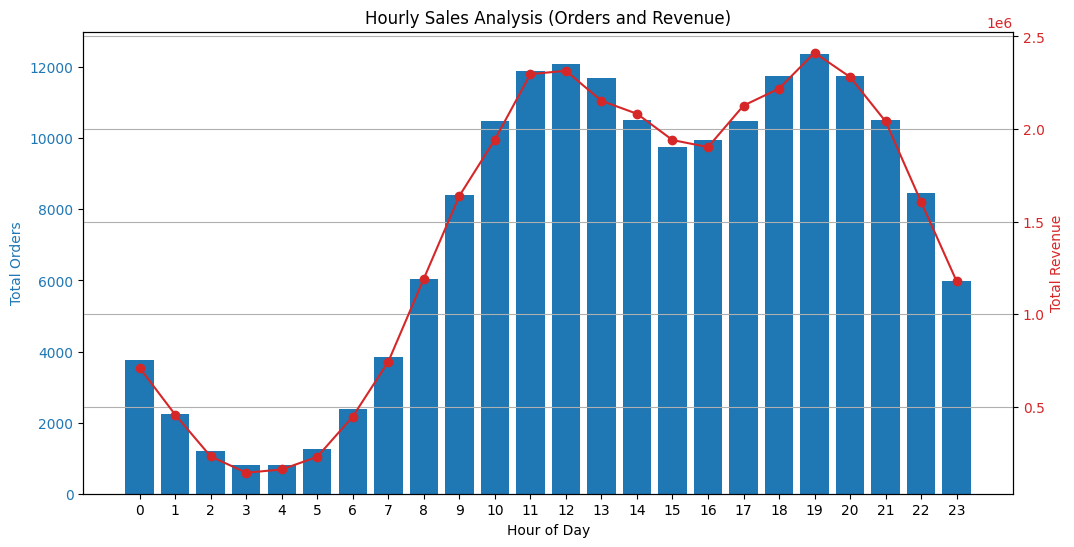

In [22]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting Total Orders
ax1.bar(hourly_sales.index, hourly_sales['Total_Orders'], color='tab:blue')
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Total Orders', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_xticks(hourly_sales.index)

# Plotting Total Revenue
ax2 = ax1.twinx()
ax2.plot(hourly_sales.index, hourly_sales['Total_Revenue'], color='tab:red', marker='o')
ax2.set_ylabel('Total Revenue', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Hourly Sales Analysis (Orders and Revenue)')
plt.grid(True)
plt.show()

Berdasarkan visualisasi, rush hours berdasar total orders dan total revenue dapat dilihat berada di jam 10.00-14.00 dan 17.00-21.00. Perusahaan bisa memberikan promo atau iklan pada customer untuk menarik melakukan transaksi lebih banyak ketika rush hours sedang berlangsung agar promo/iklan tersebut mendapat interaksi(terlihat) lebih tinggi.

# EDA

## Visualisasi Time Series

In [23]:
# Agregasi total penjualan per hari
df_daily = df.groupby(df['Order Date'].dt.date)['Total'].sum()

df.set_index('Order Date', inplace=True)

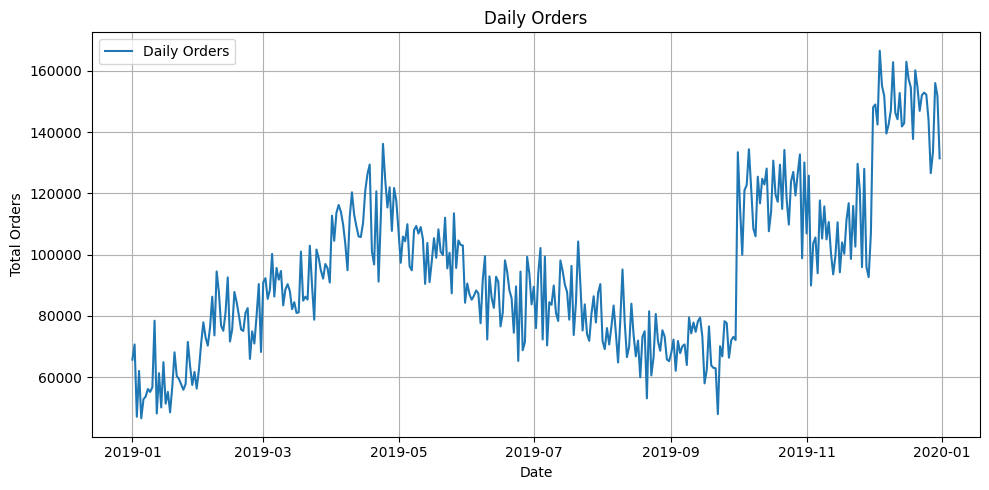

In [24]:
plt.figure(figsize=(10,5))
plt.plot(df_daily, label='Daily Orders')
plt.title('Daily Orders')
plt.xlabel('Date')
plt.ylabel('Total Orders')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

Pada akhir tahun 2019 total sales tinggi dapat dikarenakan tahun baru, promo tahun baru, ataupun natal sehingga banyak pelanggan melakukan transaksi.

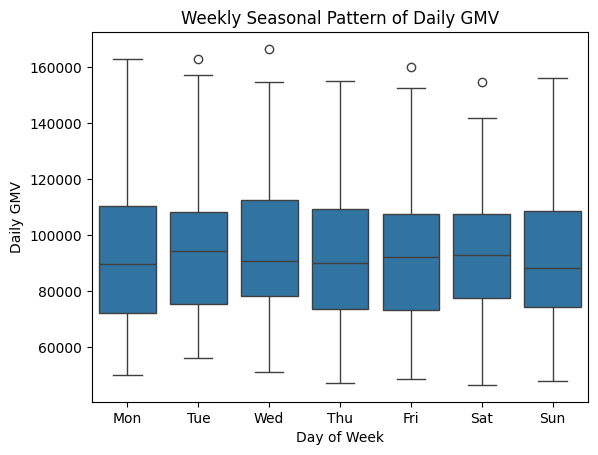

In [25]:
# Visualisasi weekly seasonal pattern
sns.boxplot(x=daily_sales.index.dayofweek, y=daily_sales['GMV'])
plt.xticks(range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.xlabel('Day of Week')
plt.ylabel('Daily GMV')
plt.title('Weekly Seasonal Pattern of Daily GMV')
plt.show()

Pembelian per harinya tidak begitu beda.

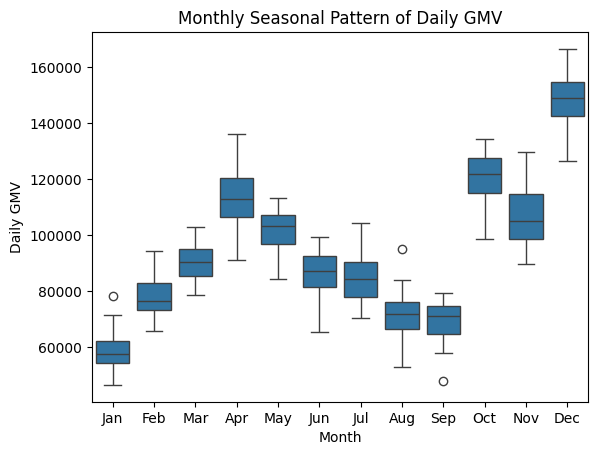

In [26]:
# Visualisasi month seasonal pattern
sns.boxplot(x=daily_sales.index.month, y=daily_sales['GMV'])
plt.xlabel('Month')
plt.ylabel('Daily GMV')
plt.title('Monthly Seasonal Pattern of Daily GMV')
plt.xticks(range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

Pada akhir tahun total sales meningkat bisa dikarenakan tahun baru dan juga promo menarik lainnya.

## Visualisasi Decomposition

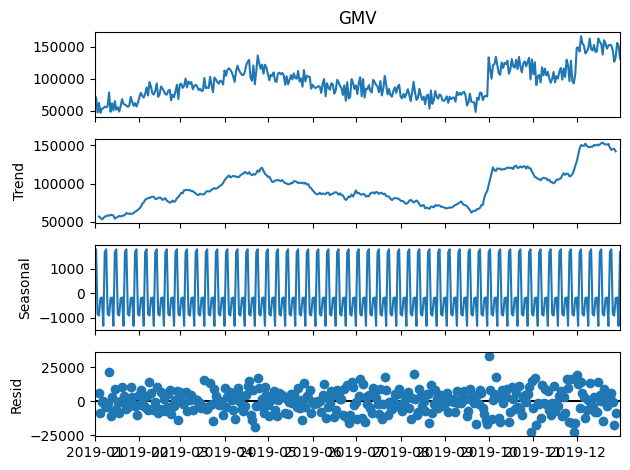

In [27]:
# Buat time series decomposition (opsional) insightnya sama kayak EDA di atas
decomposition_weekly = seasonal_decompose(daily_sales['GMV'], model='additive', period=7)
decomposition_weekly.plot()
plt.show()

## Stationarity Test (Augmented Dickey-Fuller Test - ADF))

In [28]:
# Uji Stasioneritas - ADF Test
from statsmodels.tsa.stattools import adfuller
result = adfuller(df_daily.dropna())
print("== ADF Test ==")
print(f"ADF Statistic : {result[0]}")
print(f"p-value       : {result[1]}")
for key, value in result[4].items():
    print(f"Critical Value ({key}) : {value}")
if result[1] <= 0.05:
    print("Kesimpulan: Data stasioner (tolak H0)")
else:
    print("Kesimpulan: Data tidak stasioner (gagal tolak H0)")

== ADF Test ==
ADF Statistic : -1.616561468669262
p-value       : 0.47453244224142355
Critical Value (1%) : -3.448645946352023
Critical Value (5%) : -2.869602139060357
Critical Value (10%) : -2.5710650077160495
Kesimpulan: Data tidak stasioner (gagal tolak H0)


## Plot Autocorrelation Function (ACF) dan Partial Autocorrelation Function (PACF)

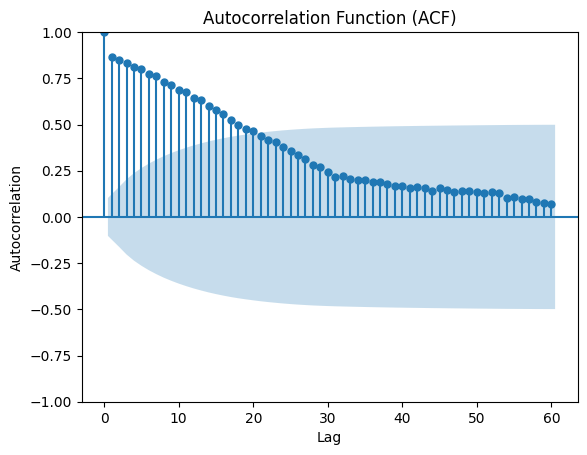

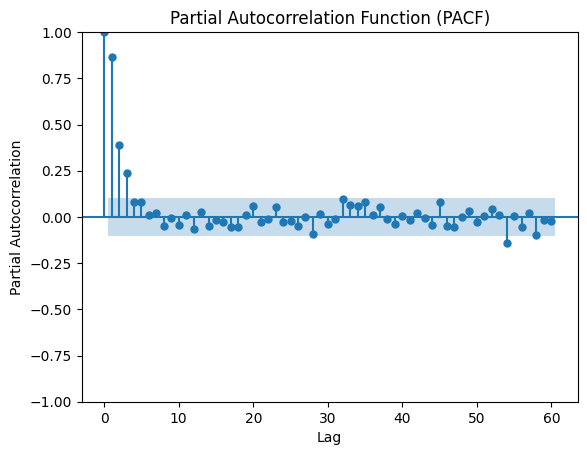

In [29]:
# Membuat Plot ACF and PACF (kalau pakai auto ARIMA gausah pakai ini)
# Plot ACF
plot_acf(daily_sales['GMV'], lags=60)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot PACF
plot_pacf(daily_sales['GMV'], lags=60)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

# Data Preparation


## Advanced Feature Engineering

In [30]:
# Ekstraksi Fitur Waktu & Kalender
def create_time_features_daily_sales(df_input): # Renamed function
    df_output = df_input.copy()
    # Ensure the index is a DatetimeIndex
    df_output.index = pd.to_datetime(df_output.index)
    df_output['year'] = df_output.index.year
    df_output['month'] = df_output.index.month
    df_output['day'] = df_output.index.day # day of month
    df_output['dayofweek'] = df_output.index.dayofweek
    df_output['dayofyear'] = df_output.index.dayofyear
    df_output['weekofyear'] = df_output.index.isocalendar().week.astype(int)
    df_output['quarter'] = df_output.index.quarter
    df_output['is_weekend'] = (df_output.index.dayofweek >= 5).astype(int) # Sabtu=5, Minggu=6

    # Fitur siklik untuk seasonal
    df_output['dayofweek_sin'] = np.sin(2 * np.pi * df_output['dayofweek']/7)
    df_output['dayofweek_cos'] = np.cos(2 * np.pi * df_output['dayofweek']/7)
    df_output['dayofyear_sin'] = np.sin(2 * np.pi * df_output['dayofyear']/365)
    df_output['dayofyear_cos'] = np.cos(2 * np.pi * df_output['dayofyear']/365)
    df_output['month_sin'] = np.sin(2 * np.pi * df_output['month']/12)
    df_output['month_cos'] = np.cos(2 * np.pi * df_output['month']/12)
    return df_output


# Pembuatan Fitur Lag & Rolling Window dari 'Total_Orders'
def create_lag_rolling_features_sales(df_input): # Renamed function
    df_temp = df_input.copy()
    target_col = 'Total_Orders' # Changed target column to 'Total_Orders'

    # Lag features dari target
    df_temp[f'{target_col}_lag_1'] = df_temp[target_col].shift(1) # Kemarin
    df_temp[f'{target_col}_lag_7'] = df_temp[target_col].shift(7) # Seminggu lalu (seasonal mingguan)
    df_temp[f'{target_col}_lag_365'] = df_temp[target_col].shift(365) # Setahun lalu (seasonal tahunan)

    # Rolling window features dari target
    df_temp[f'{target_col}_rolling_mean_7'] = df_temp[target_col].rolling(window=7, min_periods=1).mean()
    df_temp[f'{target_col}_rolling_std_7'] = df_temp[target_col].rolling(window=7, min_periods=1).std()
    df_temp[f'{target_col}_rolling_mean_30'] = df_temp[target_col].rolling(window=30, min_periods=1).mean()

    return df_temp

df_features = create_time_features_daily_sales(daily_sales) # use daily_sales which is clean


df_features = create_lag_rolling_features_sales(df_features)


# Penanganan NaN dari Fitur
# Isi NaN yang tersisa setelah shift/rolling dengan rata-rata kolom
for col in df_features.columns:
    if df_features[col].isnull().any():
        df_features[col].fillna(df_features[col].mean(), inplace=True) # Mengisi dengan rata-rata kolom

print(f"Ukuran data setelah feature engineering: {df_features.shape[0]} baris")

Ukuran data setelah feature engineering: 365 baris


## Split the Data (Time-Based Splitting)

In [31]:
# Untuk menyiapkan data sebelum pemodelan

# Pemisahan Data Training, Validasi, & Testing menggunakan Rasio
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2 # Pastikan train_ratio + val_ratio + test_ratio = 1.0

total_days = len(df_features)
train_size = int(total_days * train_ratio)
val_size = int(total_days * val_ratio)
test_size = total_days - train_size - val_size # Mengambil sisa untuk memastikan totalnya pas

# Tentukan tanggal split berdasarkan jumlah hari (untuk informasi saja)
split_date_val = df_features.index[train_size - 1]
split_date_test = df_features.index[train_size + val_size - 1]

# Definisikan target
target_col = 'Total_Orders'

# Kolom-kolom yang akan digunakan sebagai fitur (selain target) untuk model ML
ml_features = [col for col in df_features.columns if col != target_col and '_adjusted' not in col] # Exclude adjusted target

# Split data untuk model Machine Learning
X_train_ml = df_features.iloc[:train_size][ml_features]
y_train_ml = df_features.iloc[:train_size][target_col]

X_val_ml = df_features.iloc[train_size:train_size + val_size][ml_features]
y_val_ml = df_features.iloc[train_size:train_size + val_size][target_col]

X_test_ml = df_features.iloc[train_size + val_size:][ml_features]
y_test_ml = df_features.iloc[train_size + val_size:][target_col]


# Data target untuk model Time Series Klasik (jika masih diperlukan, tapi dengan 3 set)
y_train_ts = daily_sales[target_col].iloc[:train_size]
y_val_ts = daily_sales[target_col].iloc[train_size:train_size + val_size]
y_test_ts = daily_sales[target_col].iloc[train_size + val_size:]

# Fitur external/exogenous untuk SARIMAX / Prophet (untuk 3 set)
# Ini adalah kolom-kolom non-target, non-lag/rolling yang bisa jadi prediktor
exog_cols_ts = [
    'GMV',
    'year', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'quarter', 'is_weekend',
    'dayofweek_sin', 'dayofweek_cos', 'dayofyear_sin', 'dayofyear_cos', 'month_sin', 'month_cos'
]

# Filter exog_cols_ts to include only columns present in df_features
exog_cols_ts_filtered = [col for col in exog_cols_ts if col in df_features.columns]


exog_train_ts = df_features[exog_cols_ts_filtered].iloc[:train_size]
exog_val_ts = df_features[exog_cols_ts_filtered].iloc[train_size:train_size + val_size]
exog_test_ts = df_features[exog_cols_ts_filtered].iloc[train_size + val_size:]


print(f"Ukuran Data Training ML: {len(X_train_ml)} hari")
print(f"Ukuran Data Validation ML: {len(X_val_ml)} hari")
print(f"Ukuran Data Testing ML: {len(X_test_ml)} hari")
print(f"Ukuran Data Training TS: {len(y_train_ts)} hari")
print(f"Ukuran Data Validation TS: {len(y_val_ts)} hari")
print(f"Ukuran Data Testing TS: {len(y_test_ts)} hari")

Ukuran Data Training ML: 219 hari
Ukuran Data Validation ML: 73 hari
Ukuran Data Testing ML: 73 hari
Ukuran Data Training TS: 219 hari
Ukuran Data Validation TS: 73 hari
Ukuran Data Testing TS: 73 hari


# Modelling

## Fungsi untuk Evaluation Metrics & Visualisasi Model

In [32]:
# Fungsi untuk evaluasi model
def evaluate_model(y_true, y_pred, model_name):
    # Memastikan prediksi tidak negatif (karena konsumsi daya tidak mungkin negatif)
    y_pred = np.maximum(0, y_pred) # Konsumsi tidak bisa negatif
    # Menghitung Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    # Menghitung Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true, y_pred)
    # Menghitung Mean Absolute Percentage Error (MAPE)
    # Menghindari pembagian dengan nol jika ada nilai aktual 0
    y_true_cleaned = y_true.copy()
    y_true_cleaned[y_true_cleaned == 0] = 1e-9 # Ganti 0 dengan small number untuk menghindari pembagian angka 0

    mape = np.mean(np.abs((y_true - y_pred) / y_true_cleaned)) * 100
    print(f"--- {model_name} ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.2f}%")

    return rmse, mae, mape

# Fungsi untuk visualisasi perbandingan forecast vs. aktual (gabikin juga gapapa)
def plot_predictions(y_train, y_val, y_test, y_pred_val, y_pred_test, model_name):
    plt.figure(figsize=(15, 6))
    plt.plot(y_train.index, y_train, label='Data Historis (Train)', color='blue', alpha=0.7)

    if y_val is not None:
      plt.plot(y_val.index, y_val, label='Data Validasi (Aktual)', color='black', linewidth=2)
      if y_pred_val is not None:
        y_pred_val_series = pd.Series(y_pred_val, index=y_val.index)
        plt.plot(y_val.index, y_pred_val_series, label=f'Prediksi {model_name} (Validasi)', linestyle='--', color='red')


    if y_test is not None:
      plt.plot(y_test.index, y_test, label='Data Testing (Aktual)', color='green', linewidth=2)
      if y_pred_test is not None:
        y_pred_test_series = pd.Series(y_pred_test, index=y_test.index)
        plt.plot(y_test.index, y_pred_test_series, label=f'Prediksi {model_name} (Testing)', linestyle='--', color='orange')


    plt.title(f'Prediksi {model_name} vs. Aktual', fontsize=16)
    plt.xlabel('Tanggal', fontsize=12)
    plt.ylabel('Total Orders', fontsize=12)

    plt.axvline(x=y_train.index.max(), color='grey', linestyle=':', label='Akhir Data Historis')

    if y_val is not None and len(y_val) > 0:
      plt.axvline(x=y_val.index.max(), color='gray', linestyle='--', label='Akhir Data Validasi')

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Exponential Smoothing (Holt-Winters)

--- Holt-Winters (Validation) ---
RMSE: 127.3709
MAE: 74.8900
MAPE: 13.21%


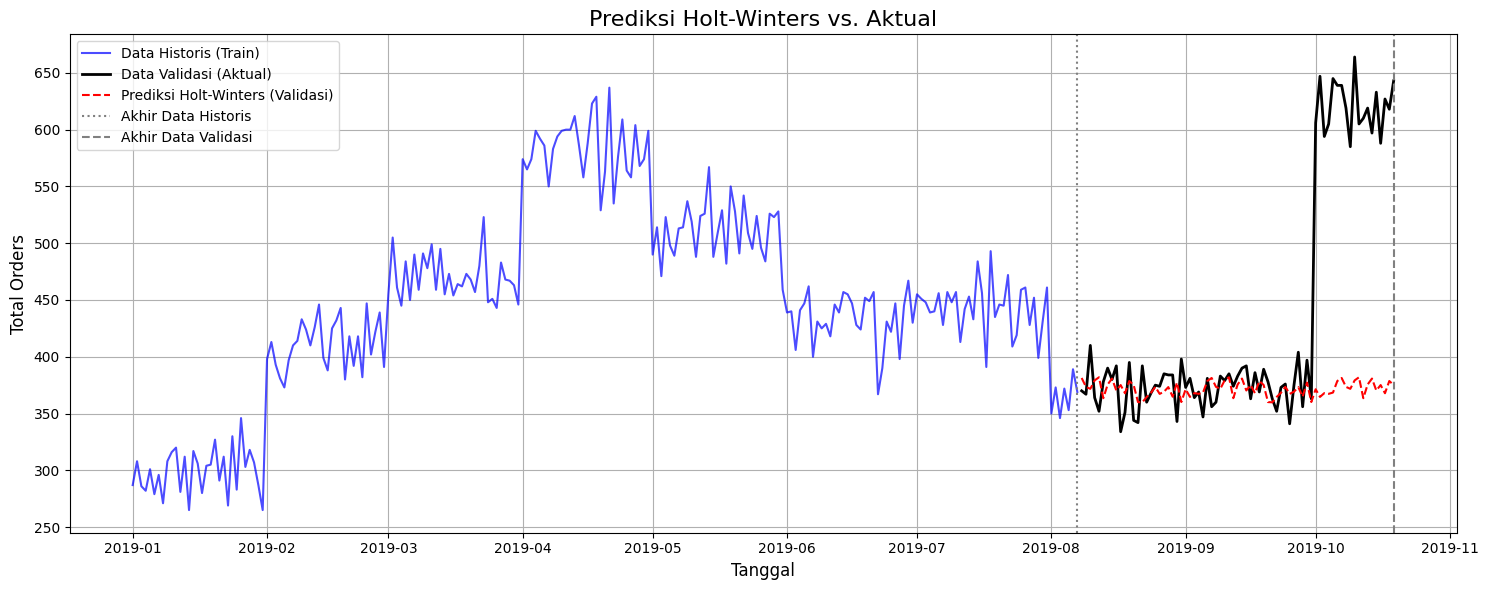

In [33]:
# Pemodelan
hw_model = ExponentialSmoothing(y_train_ts, seasonal='multiplicative', seasonal_periods=30).fit() # latih model
y_pred_hw_val = hw_model.forecast(len(y_val_ts)) # prediksi

rmse_hw_val, mae_hw_val, mape_hw_val = evaluate_model(y_val_ts, y_pred_hw_val, "Holt-Winters (Validation)")
plot_predictions(y_train_ts, y_val_ts, None, y_pred_hw_val, None, "Holt-Winters")

## Random Forest Regressor

--- Random Forest Regressor (Validation) ---
RMSE: 50.9408
MAE: 33.0084
MAPE: 6.58%


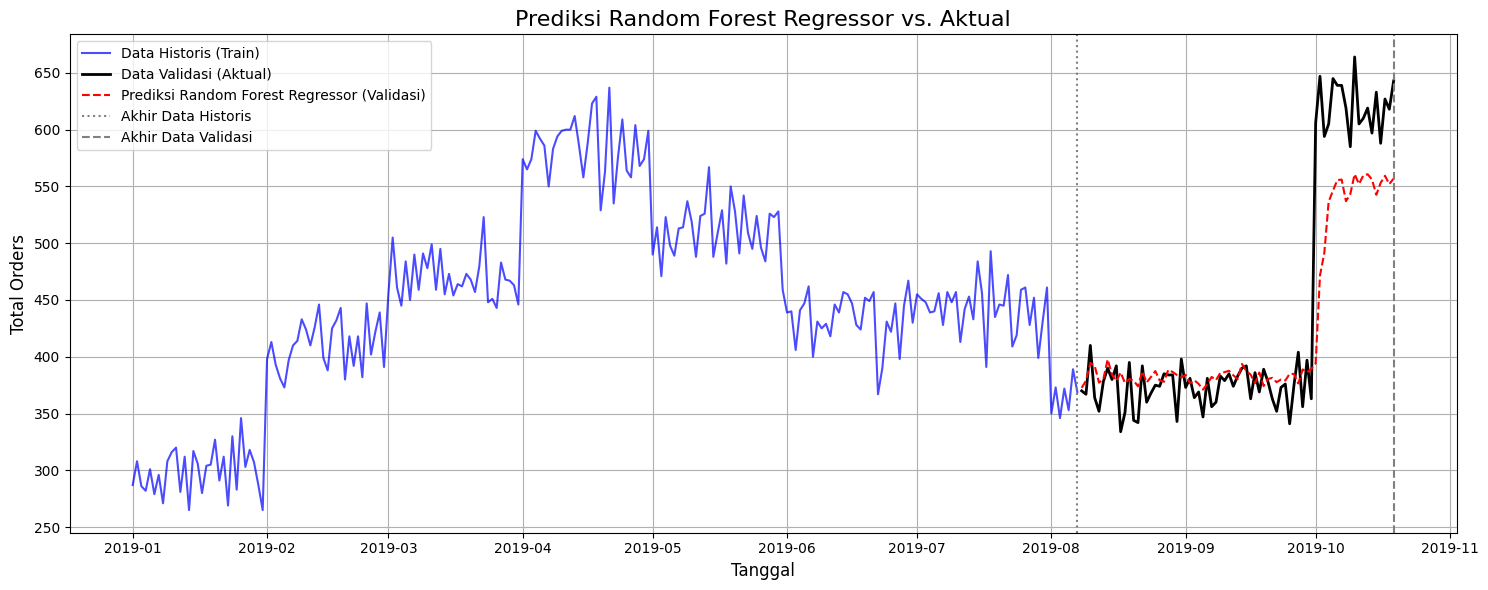

In [34]:
# Pemodelan

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_ml, y_train_ml)

y_pred_rf_val = rf_model.predict(X_val_ml)

rmse_rf_val, mae_rf_val, mape_rf_val = evaluate_model(y_val_ml, y_pred_rf_val, "Random Forest Regressor (Validation)")
plot_predictions(y_train_ml, y_val_ml, None, y_pred_rf_val, None, "Random Forest Regressor")

Evaluating the Best Model (Random Forest Regressor) on the Test Set:
--- Random Forest Regressor (Test) ---
RMSE: 106.0702
MAE: 83.4523
MAPE: 11.54%


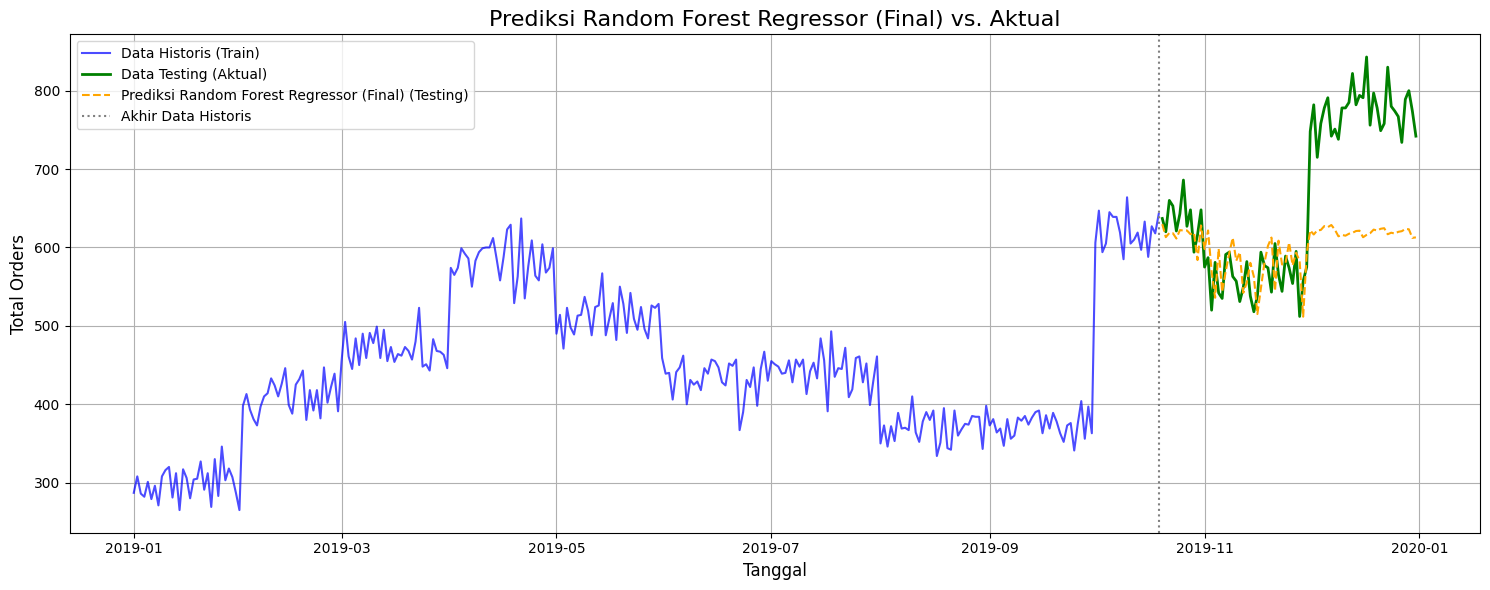

In [35]:
best_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

X_train_val_ml = pd.concat([X_train_ml, X_val_ml])
y_train_val_ml = pd.concat([y_train_ml, y_val_ml])

best_model.fit(X_train_val_ml, y_train_val_ml)

y_pred_test_best_model = best_model.predict(X_test_ml)

print("Evaluating the Best Model (Random Forest Regressor) on the Test Set:")
rmse_test_best, mae_test_best, mape_test_best = evaluate_model(y_test_ml, y_pred_test_best_model, "Random Forest Regressor (Test)")

plot_predictions(y_train_val_ml, None, y_test_ml, None, y_pred_test_best_model, "Random Forest Regressor (Final)")

Berdasarkan hasil diatas, model Random Forest memiliki nilai MAPE yang lebih baik dari hasil validation (6.58%) dibandingkan dengan Holt-Winters (13.21%). Meskipun hasil pada data test Random Forest lebih tinggi dibandingkan hasil validationnya, Random Forest masih memberikan perkiraan yang lebih akurat daripada model Holt-Winters. Random Forest merupakan pilihan model terbaik dari kedua modelling yang dilakukan.

Rekomendasi :

- Model berhasil memprediksi penjualan terkecuali lonjakan akhir tahun, gunakan hasil prediksi yang akurat untuk perencanaan stock harian/mingguan/bulanan. Hal tersebut juga bisa dipakai untuk menentukan target penjualan harian.
- Data yang terprediksi bisa mencegah understock saat permintaan tinggi dan overstock pada penjualan renah. Forecast ini dapat diimplementasikan pada bagian logistik.
- Lonjakan akhir tahun kemungkinan adanya liburan, promo, atau natal. Pada saat ini kita dapat melakukan menyiapkan stock dan juga menambah promo lagi untuk meningkatkan transaksi pada pelanggan.
- Optimalkan penempatan staff pada saat rush hour untuk memaksimalkan pelayanan.
- Melakukan promo bundling. Kombinasi bundling produk yang teridentifikasi, sebaiknya perusahaan membuat penawaran bundling untuk item yang sering dibeli bersamaan. Ini dapat meningkatkan nilai transaksi rata-rata dan mendorong pelanggan untuk membeli lebih banyak produk.

# Github
